# Reconnaissance de l'Alphabet de la Langue des Signes (ASL) - Version Kaggle

Ce notebook est optimisé pour l'environnement **Kaggle Kernel**.

## Prérequis Kaggle
1.  Ajoutez le dataset **ASL Alphabet** à votre nterook : 
    - Cliquez sur **Add Data** (à droite).
    - Cherchez "ASL Alphabet" (uploadé par Akash Nagaraj ou similaire).
    - Le chemin devrait être `/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train`.

## Sections
1. **Configuration (Chemins Kaggle)**
2. **Pipeline de Données**
3. **Architecture Modulaire** (CNN Custom & MobileNetV2)
4. **Moteur d'Entraînement**
5. **Analyse de Performance**
6. **Inférence Webcam (Capture JS)**


In [11]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import cv2

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

PyTorch Version: 2.8.0+cu126
CUDA disponible: True


## 1. Configuration & Hyperparamètres

Adaptation automatique des chemins pour Kaggle.

In [12]:
class Config:
    # Détection environnement
    IS_KAGGLE = os.path.exists("/kaggle/input")
    
    # Chemins
    if IS_KAGGLE:
        # Chemin standard du dataset 'asl-alphabet' sur Kaggle
        # Note: Le chemin exact peut varier selon le dataset ajouté. Vérifiez avec os.listdir("/kaggle/input") si erreur.
        if os.path.exists("/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"):
             DATA_DIR = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
        elif os.path.exists("/kaggle/input/asl-alphabet-test/asl_alphabet_train/asl_alphabet_train"):
             DATA_DIR = "/kaggle/input/asl-alphabet-test/asl_alphabet_train/asl_alphabet_train"
        else:
             # Fallback ou chemin à adapter manuellement
             print("ATTENTION: Chemin dataset Kaggle non trouvé automatiquement. Vérifiez vos Données.")
             DATA_DIR = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
             
        MODEL_SAVE_PATH = "/kaggle/working/asl_model.pth"
    else:
        DATA_DIR = "./data/asl_alphabet_train/asl_alphabet_train"
        MODEL_SAVE_PATH = "asl_model.pth"
    
    # Hyperparamètres
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    EPOCHS = 10
    IMG_SIZE = 224 
    NUM_CLASSES = 29 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def __str__(self):
        return f"Config(Env={'Kaggle' if self.IS_KAGGLE else 'Local'}, Device={self.DEVICE})\nData: {self.DATA_DIR}"

config = Config()
print(config)

# Vérification rapide du contenu du dossier
if os.path.exists(config.DATA_DIR):
    print("Dossiers trouvés (premiers 5):", os.listdir(config.DATA_DIR)[:5])
else:
    print(f"\n❌ ERREUR: Le dossier {config.DATA_DIR} n'existe pas.\n-> Ajoutez le dataset 'ASL Alphabet' via le menu Kaggle 'Add Data'.")

Config(Env=Kaggle, Device=cuda)
Data: /kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train
Dossiers trouvés (premiers 5): ['N', 'R', 'space', 'B', 'I']


## 2. Pipeline de Données

In [13]:
def get_data_transforms():
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

def get_dataloaders(data_dir):
    transforms_dict = get_data_transforms()
    
    if not os.path.exists(data_dir):
        print("Utilisation de FakeData (Mode Demo) car dataset absent.")
        train_dataset = datasets.FakeData(size=100, image_size=(3, config.IMG_SIZE, config.IMG_SIZE), num_classes=29, transform=transforms_dict['train'])
        val_dataset = datasets.FakeData(size=20, image_size=(3, config.IMG_SIZE, config.IMG_SIZE), num_classes=29, transform=transforms_dict['val'])
        class_names = [str(i) for i in range(29)]
    else:
        # Chargement complet et split 80/20
        full_dataset = datasets.ImageFolder(data_dir)
        class_names = full_dataset.classes
        config.NUM_CLASSES = len(class_names)
        
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        
        # Astuce pour avoir des transformations différentes sur Train/Val
        # On charge deux fois le dataset (c'est léger, ce ne sont que des chemins)
        train_ds_root = datasets.ImageFolder(data_dir, transform=transforms_dict['train'])
        val_ds_root = datasets.ImageFolder(data_dir, transform=transforms_dict['val'])
        
        indices = torch.randperm(len(full_dataset)).tolist()
        train_dataset = torch.utils.data.Subset(train_ds_root, indices[:train_size])
        val_dataset = torch.utils.data.Subset(val_ds_root, indices[train_size:])

    print(f"Classes : {len(class_names)} | Train : {len(train_dataset)} | Val : {len(val_dataset)}")
    
    # Num_workers > 0 recommandé sur Kaggle (2 ou 4)
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, class_names

train_loader, val_loader, class_names = get_dataloaders(config.DATA_DIR)

Classes : 29 | Train : 69600 | Val : 17400


## 3. Architecture Modulaire

In [14]:
class ASLModel(nn.Module):
    def __init__(self, num_classes):
        super(ASLModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.flatten_dim = 128 * (config.IMG_SIZE // 8) * (config.IMG_SIZE // 8)
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def get_model(use_pretrained=False, num_classes=29):
    if use_pretrained:
        print("Chargement MobileNetV2...")
        model = models.mobilenet_v2(weights='DEFAULT')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        print("Création ASLModel Custom...")
        model = ASLModel(num_classes)
    return model.to(config.DEVICE)

## 4. Entraînement

In [15]:
def train_model(model, loaders, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders[phase]:
                inputs = inputs.to(config.DEVICE)
                labels = labels.to(config.DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(loaders[phase].dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'  {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best Val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

# Exécution
model = get_model(use_pretrained=True, num_classes=config.NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

model, history = train_model(model, {'train': train_loader, 'val': val_loader}, 
                             criterion, optimizer, epochs=config.EPOCHS)

torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
print(f"Sauvegardé dans {config.MODEL_SAVE_PATH}")

Chargement MobileNetV2...
Epoch 1/10
  train Loss: 0.1153 Acc: 0.9684
  val Loss: 0.0146 Acc: 0.9963
Epoch 2/10
  train Loss: 0.0249 Acc: 0.9926
  val Loss: 0.0073 Acc: 0.9975
Epoch 3/10
  train Loss: 0.0220 Acc: 0.9934
  val Loss: 0.0085 Acc: 0.9979
Epoch 4/10
  train Loss: 0.0149 Acc: 0.9959
  val Loss: 0.0055 Acc: 0.9980
Epoch 5/10
  train Loss: 0.0192 Acc: 0.9941
  val Loss: 0.0115 Acc: 0.9968
Epoch 6/10
  train Loss: 0.0112 Acc: 0.9965
  val Loss: 0.0042 Acc: 0.9992
Epoch 7/10
  train Loss: 0.0136 Acc: 0.9962
  val Loss: 0.0131 Acc: 0.9954
Epoch 8/10
  train Loss: 0.0103 Acc: 0.9969
  val Loss: 0.0008 Acc: 0.9997
Epoch 9/10
  train Loss: 0.0127 Acc: 0.9961
  val Loss: 0.0070 Acc: 0.9979
Epoch 10/10
  train Loss: 0.0091 Acc: 0.9974
  val Loss: 0.0038 Acc: 0.9988
Best Val Acc: 0.9997
Sauvegardé dans /kaggle/working/asl_model.pth


## 5. Analyse

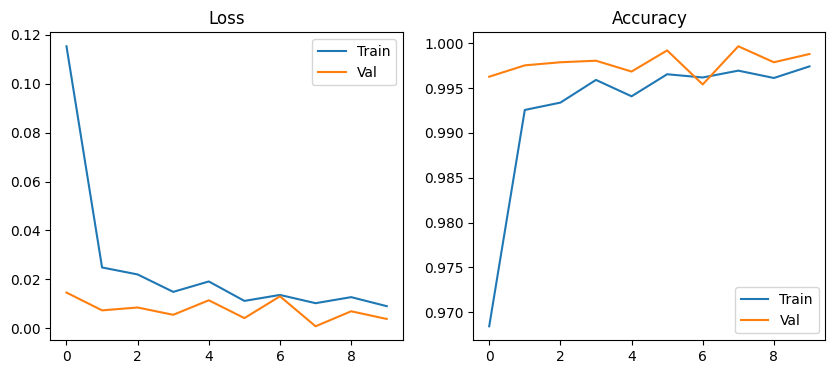

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy')
plt.legend()
plt.show()

## 6. Inférence Webcam (Javascript)

Sur Kaggle/Colab, on ne peut pas ouvrir la webcam en Python direct. Utilisation de JS pour capturer une photo.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Prendre Photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
    print("Cliquez sur 'Prendre Photo' ci-dessous...")
    filename = take_photo()
    
    # Inférence
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    inp = transform(image).unsqueeze(0).to(config.DEVICE)
    model.eval()
    with torch.no_grad():
        out = model(inp)
        probs = torch.nn.functional.softmax(out, dim=1)
        score, idx = torch.max(probs, 1)
        print(f"\nPrédiction : {class_names[idx.item()]} (Confiance: {score.item()*100:.1f}%)")
        
except Exception as e:
    print(f"Pas de webcam détectée ou erreur JS : {e}")

Cliquez sur 'Prendre Photo' ci-dessous...


<IPython.core.display.Javascript object>